In [1]:
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, model_from_json
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM, concatenate , Input, Reshape, Dense
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np

Using TensorFlow backend.


In [0]:
mkdir resources


In [0]:
mkdir compiler

In [7]:
cd resources

/content/resources


In [0]:
mkdir eval_light

In [9]:
from google.colab import files
uploaded = files.upload()

Saving bootstrap.vocab to bootstrap.vocab
Saving example.png to example.png


In [10]:
cd  eval_light

/content/resources/eval_light


In [11]:
from google.colab import files
uploaded = files.upload()

Saving 00CDC9A8-3D73-4291-90EF-49178E408797.gui to 00CDC9A8-3D73-4291-90EF-49178E408797.gui
Saving 00CDC9A8-3D73-4291-90EF-49178E408797.npz to 00CDC9A8-3D73-4291-90EF-49178E408797.npz
Saving 0BA2A4B4-4193-4506-8818-31564225EF8B.gui to 0BA2A4B4-4193-4506-8818-31564225EF8B.gui
Saving 0BA2A4B4-4193-4506-8818-31564225EF8B.npz to 0BA2A4B4-4193-4506-8818-31564225EF8B.npz
Saving 0CC0512B-11C5-481C-BC81-534F1FC9EC0A.gui to 0CC0512B-11C5-481C-BC81-534F1FC9EC0A.gui
Saving 0CC0512B-11C5-481C-BC81-534F1FC9EC0A.npz to 0CC0512B-11C5-481C-BC81-534F1FC9EC0A.npz
Saving 0D1C8ADB-D9F0-48EC-B5AA-205BCF96094E.gui to 0D1C8ADB-D9F0-48EC-B5AA-205BCF96094E.gui
Saving 0D1C8ADB-D9F0-48EC-B5AA-205BCF96094E.npz to 0D1C8ADB-D9F0-48EC-B5AA-205BCF96094E.npz
Saving 0FBAB0B3-24CB-42EF-8803-BFDEB8C3EFDC.gui to 0FBAB0B3-24CB-42EF-8803-BFDEB8C3EFDC.gui
Saving 0FBAB0B3-24CB-42EF-8803-BFDEB8C3EFDC.npz to 0FBAB0B3-24CB-42EF-8803-BFDEB8C3EFDC.npz
Saving 1A5D96CE-F23A-4EB5-84BF-F6F2A3B6D185.gui to 1A5D96CE-F23A-4EB5-84BF-F6F2A

In [12]:
pwd

'/content/resources/eval_light'

In [13]:
cd /content

/content


In [14]:
pwd

'/content'

In [0]:
dir_name = 'resources/eval_light/'

# Read a file and return a string
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_data(data_dir):
    text = []
    images = []
    # Load all the files and order them
    all_filenames = listdir(data_dir)
    all_filenames.sort()
    for filename in (all_filenames):
        if filename[-3:] == "npz":
            # Load the images already prepared in arrays
            image = np.load(data_dir+filename)
            images.append(image['features'])
        else:
            # Load the boostrap tokens and rap them in a start and end tag
            syntax = '<START> ' + load_doc(data_dir+filename) + ' <END>'
            # Seperate all the words with a single space
            syntax = ' '.join(syntax.split())
            # Add a space after each comma
            syntax = syntax.replace(',', ' ,')
            text.append(syntax)
    images = np.array(images, dtype=float)
    return images, text

train_features, texts = load_data(dir_name)

In [19]:
print(train_features.shape)
print(len(texts))
print(texts)

(10, 256, 256, 3)
10
['<START> header { btn-inactive , btn-active , btn-inactive , btn-inactive , btn-inactive } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-red } quadruple { small-title , text , btn-green } quadruple { small-title , text , btn-orange } } row { single { small-title , text , btn-green } } <END>', '<START> header { btn-inactive , btn-inactive , btn-active , btn-inactive , btn-inactive } row { double { small-title , text , btn-green } double { small-title , text , btn-green } } row { single { small-title , text , btn-orange } } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-green } quadruple { small-title , text , btn-red } quadruple { small-title , text , btn-green } } <END>', '<START> header { btn-inactive , btn-inactive , btn-inactive , btn-active } row { double { small-title , text , btn-green } double { small-title , text , btn-green } } row { single { small-title , text , btn-oran

In [0]:
# Initialize the function to create the vocabulary 
tokenizer = Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary 
tokenizer.fit_on_texts([load_doc('resources/bootstrap.vocab')])

# Add one spot for the empty word in the vocabulary 
vocab_size = len(tokenizer.word_index) + 1
# Map the input sentences into the vocabulary indexes
train_sequences = tokenizer.texts_to_sequences(texts)
# The longest set of boostrap tokens
max_sequence = max(len(s) for s in train_sequences)
# Specify how many tokens to have in each input sentence
max_length = 48

def preprocess_data(sequences, features):
    X, y, image_data = list(), list(), list()
    for img_no, seq in enumerate(sequences):
        for i in range(1, len(seq)):
            # Add the sentence until the current count(i) and add the current count to the output
            in_seq, out_seq = seq[:i], seq[i]
            # Pad all the input token sentences to max_sequence
            in_seq = pad_sequences([in_seq], maxlen=max_sequence)[0]
            # Turn the output into one-hot encoding
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Add the corresponding image to the boostrap token file
            image_data.append(features[img_no])
            # Cap the input sentence to 48 tokens and add it
            X.append(in_seq[-48:])
            y.append(out_seq)
    return np.array(X), np.array(y), np.array(image_data)

X, y, image_data = preprocess_data(train_sequences, train_features)

In [21]:
print(X.shape)
print(y.shape)
print(image_data.shape)

(694, 48)
(694, 18)
(694, 256, 256, 3)


In [0]:
#Create the encoder
image_model = Sequential()
image_model.add(Conv2D(16, (3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3,)))
image_model.add(Conv2D(16, (3,3), activation='relu', padding='same', strides=2))
image_model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
image_model.add(Conv2D(32, (3,3), activation='relu', padding='same', strides=2))
image_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
image_model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2))
image_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))

image_model.add(Flatten())
image_model.add(Dense(1024, activation='relu'))
image_model.add(Dropout(0.3))
image_model.add(Dense(1024, activation='relu'))
image_model.add(Dropout(0.3))

image_model.add(RepeatVector(max_length))

visual_input = Input(shape=(256, 256, 3,))
encoded_image = image_model(visual_input)

language_input = Input(shape=(max_length,))
language_model = Embedding(vocab_size, 50, input_length=max_length, mask_zero=True)(language_input)
language_model = LSTM(128, return_sequences=True)(language_model)
language_model = LSTM(128, return_sequences=True)(language_model)

#Create the decoder
decoder = concatenate([encoded_image, language_model])
decoder = LSTM(512, return_sequences=True)(decoder)
decoder = LSTM(512, return_sequences=False)(decoder)
decoder = Dense(vocab_size, activation='softmax')(decoder)

# Compile the model
model = Model(inputs=[visual_input, language_input], outputs=decoder)
optimizer = RMSprop(lr=0.0001, clipvalue=1.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'] )

In [0]:
#Save the model for every 2nd epoch
filepath="org-weights-epoch-{epoch:04d}--val_loss-{val_loss:.4f}--loss-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=True, period=2)
callbacks_list = [checkpoint]

In [26]:
# Train the model
history = model.fit([image_data, X], y, batch_size=1, shuffle=False, validation_split=0.1, callbacks=callbacks_list, verbose=1, epochs=50)

Train on 624 samples, validate on 70 samples
Epoch 1/50
624/624 [==============================] - 279s 447ms/step - loss: 2.5164 - acc: 0.1987 - val_loss: 2.3843 - val_acc: 0.2286
Epoch 2/50
624/624 [==============================] - 267s 428ms/step - loss: 2.3960 - acc: 0.2115 - val_loss: 2.3296 - val_acc: 0.2429

Epoch 00002: saving model to org-weights-epoch-0002--val_loss-2.3296--loss-2.3960.hdf5
Epoch 3/50
624/624 [==============================] - 268s 430ms/step - loss: 2.3308 - acc: 0.2019 - val_loss: 2.3140 - val_acc: 0.2429
Epoch 4/50
624/624 [==============================] - 263s 422ms/step - loss: 2.1112 - acc: 0.2788 - val_loss: 2.6817 - val_acc: 0.2000

Epoch 00004: saving model to org-weights-epoch-0004--val_loss-2.6817--loss-2.1112.hdf5
Epoch 5/50
624/624 [==============================] - 264s 423ms/step - loss: 1.7264 - acc: 0.3766 - val_loss: 2.1509 - val_acc: 0.3429
Epoch 6/50
624/624 [==============================] - 264s 423ms/step - loss: 1.4295 - acc: 0.5096 

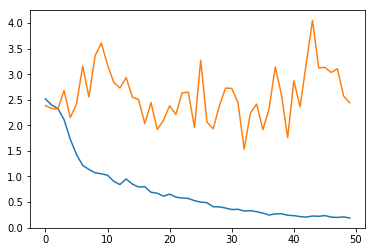

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.show()

In [0]:
from keras.models import load_model
model.save('bootstrap_model.h5')
#model = load_model('html_model.h5')

In [0]:
model.save_weights('bootstrap_weight.hdf5')

In [34]:
from google.colab import files
files.download("bootstrap_model.h5")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 40240, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil